In [1]:
# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Konfigurasi tampilan pandas
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- STEP 2: Data Loading & Cleaning ---

def load_and_clean_data(filepath):
    # Load Data
    df = pd.read_csv(filepath)
    
    # Hapus kolom index yang tidak perlu
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Cleaning kolom Salary (Hapus koma, ubah ke numeric)
    # Pastikan tipe datanya string sebelum replace
    if df['Salary_In_Rupees'].dtype == 'O': 
        df['Salary_In_Rupees'] = df['Salary_In_Rupees'].str.replace(',', '').astype(float)
        
    return df

# Eksekusi
df = load_and_clean_data("Data_Science_Fields_Salary_Categorization.csv")
print("Info Data:")
df.info()
print("\nStatistik Salary:")
print(df['Salary_In_Rupees'].describe())
df.shape

Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Working_Year          607 non-null    int64  
 1   Designation           607 non-null    object 
 2   Experience            607 non-null    object 
 3   Employment_Status     607 non-null    object 
 4   Salary_In_Rupees      607 non-null    float64
 5   Employee_Location     607 non-null    object 
 6   Company_Location      607 non-null    object 
 7   Company_Size          607 non-null    object 
 8   Remote_Working_Ratio  607 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 42.8+ KB

Statistik Salary:
count    6.070000e+02
mean     8.935485e+06
std      5.646034e+06
min      2.274890e+05
25%      4.991076e+06
50%      8.081874e+06
75%      1.193542e+07
max      4.774170e+07
Name: Salary_In_Rupees, dtype: float64


(607, 9)


Distribusi Kategori Gaji:
salary_category
Medium    233
High      221
Low       153
Name: count, dtype: int64


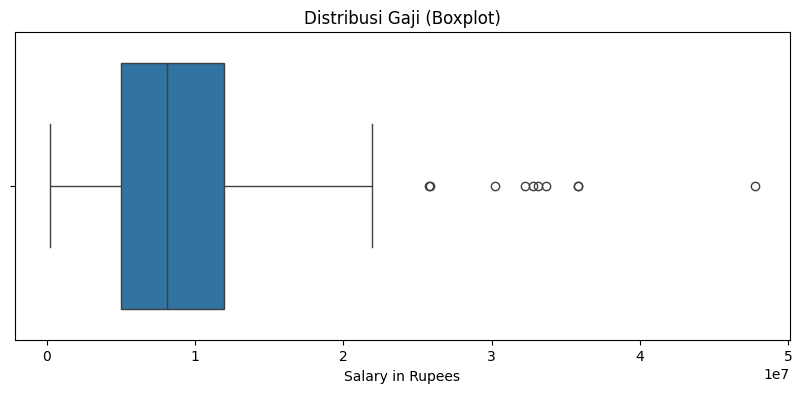

In [3]:
# --- STEP 3: Feature Engineering ---

def categorize_salary(salary):
    if salary < 5_000_000:
        return 'Low'
    elif salary <= 10_000_000:
        return 'Medium'
    else: 
        return 'High'

# Terapkan fungsi
df['salary_category'] = df['Salary_In_Rupees'].apply(categorize_salary)

# Cek distribusi target
print("\nDistribusi Kategori Gaji:")
print(df['salary_category'].value_counts())

# Visualisasi Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Salary_In_Rupees'])
plt.title("Distribusi Gaji (Boxplot)")
plt.xlabel("Salary in Rupees")
plt.show()

In [4]:
# --- STEP 4: Preprocessing (Perbaikan) ---

# 1. Tentukan Target (y) dari dataframe ASLI (sebelum diapa-apakan)
y = df['salary_category']

# 2. Tentukan Fitur Mentah (X_raw)
# Kita buang 'Salary_In_Rupees' (karena sudah diwakili kategori, opsional)
# Kita buang 'salary_category' (karena ini adalah target/jawaban, HARUS DIBUANG dari X)
X_raw = df.drop(columns=['Salary_In_Rupees', 'salary_category'])

# 3. Lakukan One-Hot Encoding HANYA pada Fitur (X)
# Ini akan mengubah kolom teks seperti 'Designation', 'Company_Location' menjadi angka
X = pd.get_dummies(X_raw, drop_first=True)

# 4. Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 5. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing Selesai.")
print(f"Dimensi Fitur (X): {X.shape}")
print(f"Dimensi Target (y): {y.shape}")                 

Preprocessing Selesai.
Dimensi Fitur (X): (607, 164)
Dimensi Target (y): (607,)


--- Decision Tree Results ---
Accuracy: 0.6284

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.75      0.71        67
         Low       0.68      0.61      0.64        46
      Medium       0.54      0.53      0.53        70

    accuracy                           0.63       183
   macro avg       0.63      0.63      0.63       183
weighted avg       0.63      0.63      0.63       183



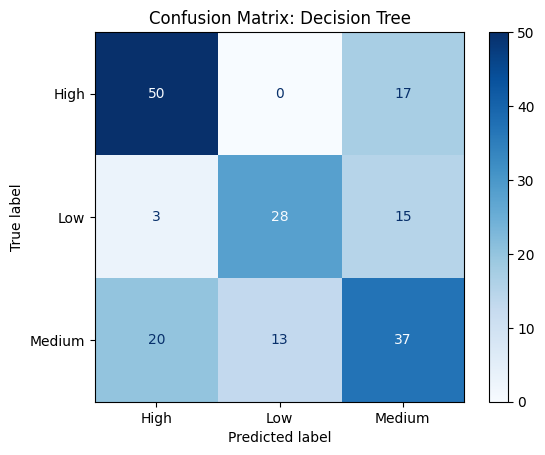

--------------------------------------------------
--- Random Forest Results ---
Accuracy: 0.6612

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.78      0.73        67
         Low       0.71      0.65      0.68        46
      Medium       0.60      0.56      0.58        70

    accuracy                           0.66       183
   macro avg       0.67      0.66      0.66       183
weighted avg       0.66      0.66      0.66       183



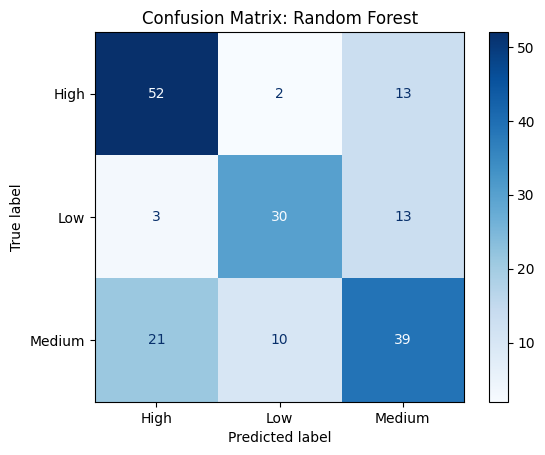

--------------------------------------------------
--- KNN (k=5) Results ---
Accuracy: 0.6120

Classification Report:
              precision    recall  f1-score   support

        High       0.59      0.94      0.73        67
         Low       0.84      0.46      0.59        46
      Medium       0.54      0.40      0.46        70

    accuracy                           0.61       183
   macro avg       0.66      0.60      0.59       183
weighted avg       0.63      0.61      0.59       183



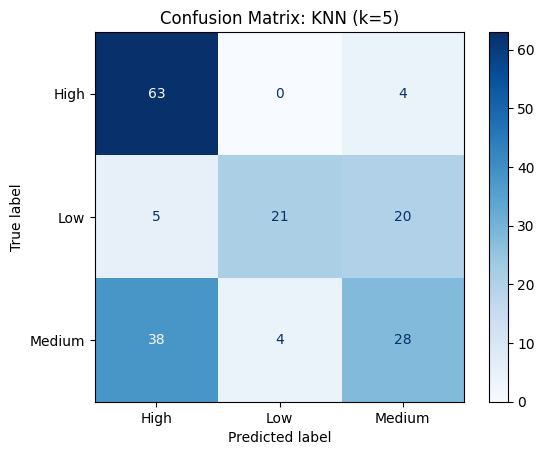

--------------------------------------------------


In [5]:
# --- STEP 5: Model Training & Evaluation Functions ---

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()
    print("-" * 50)
    
    return acc

# --- Eksekusi Model ---

# 1. Decision Tree (Tidak butuh scaling, tapi pakai scaled tidak masalah)
dt_acc = evaluate_model(DecisionTreeClassifier(random_state=42), 
                        X_train, X_test, y_train, y_test, 
                        "Decision Tree")

# 2. Random Forest
rf_acc = evaluate_model(RandomForestClassifier(random_state=42), 
                        X_train, X_test, y_train, y_test, 
                        "Random Forest")

# 3. KNN (Wajib pakai X_scaled)
knn_acc = evaluate_model(KNeighborsClassifier(n_neighbors=5), 
                         X_train_scaled, X_test_scaled, y_train, y_test, 
                         "KNN (k=5)")

--- Cross Validation Scores (5 Folds) ---
Decision Tree: 0.5931 (+/- 0.0278)
Random Forest: 0.6097 (+/- 0.0334)
KNN: 0.5584 (+/- 0.0646)

--- Tuning K for KNN ---


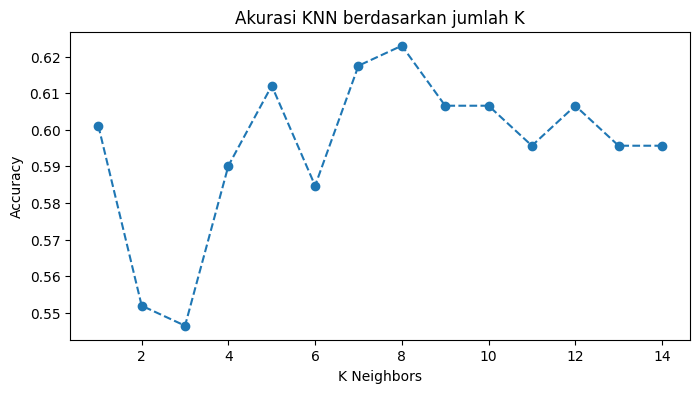

K terbaik ditemukan: 8 dengan akurasi 0.6230


In [6]:
# --- STEP 6: Cross Validation & Comparison ---

# Kita perlu menskalakan seluruh X untuk CV yang akurat pada KNN (idealnya pakai Pipeline, tapi ini cara simpel)
X_scaled_full = scaler.fit_transform(X)

models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42), X), # Tree tidak wajib scale
    ("Random Forest", RandomForestClassifier(random_state=42), X),
    ("KNN", KNeighborsClassifier(n_neighbors=5), X_scaled_full)    # KNN wajib scale
]

print("--- Cross Validation Scores (5 Folds) ---")
for name, model, X_data in models:
    scores = cross_val_score(model, X_data, y, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Opsional: Tuning nilai K untuk KNN
print("\n--- Tuning K for KNN ---")
best_k = 0
best_acc = 0
k_history = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    k_history.append(score)
    if score > best_acc:
        best_acc = score
        best_k = k

plt.figure(figsize=(8, 4))
plt.plot(range(1, 15), k_history, marker='o', linestyle='--')
plt.title("Akurasi KNN berdasarkan jumlah K")
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.show()

print(f"K terbaik ditemukan: {best_k} dengan akurasi {best_acc:.4f}")

In [8]:
# 1. Import (if not already imported)
from sklearn.ensemble import RandomForestClassifier
import joblib

# 2. Define & Retrain the Model
# We retrain using the existing training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) 

print("Random Forest model successfully retrained!")

# 3. Now save the Model and Scaler
joblib.dump(rf_model, 'best_model_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler successfully saved to .pkl files!")

Random Forest model successfully retrained!
Model and Scaler successfully saved to .pkl files!
